# 3.1 Image data augmentation
케라스에서는 ImageDataGenerate 함수로 Data augmentation 기능을  제공

https://keras.io/preprocessing/image/#imagedatagenerator-class

In [1]:
import numpy as np
from tensorflow.keras import datasets
import tensorflow.keras.utils as utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation
from tensorflow.keras.layers import Flatten, BatchNormalization, Dropout, ReLU
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

2022-04-13 16:41:40.433296: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
(X_trainOrg, Y_trainOrg),(X_testOrg, Y_testOrg) = datasets.mnist.load_data()
print(X_trainOrg.shape, Y_trainOrg.shape)

(60000, 28, 28) (60000,)


In [3]:
X_train_flat = X_trainOrg.reshape(60000, 28*28).astype('float32')/255.0
X_test_flat = X_testOrg.reshape(10000, 28*28).astype('float32')/255.0

X_train = X_trainOrg.reshape(X_trainOrg.shape[0], X_trainOrg.shape[1], X_trainOrg.shape[2], 1)
X_test = X_testOrg.reshape(X_testOrg.shape[0], X_testOrg.shape[1], X_testOrg.shape[2], 1)

Y_train = utils.to_categorical(Y_trainOrg)
Y_test = utils.to_categorical(Y_testOrg)

print(X_train.shape, Y_train.shape)

n_in = X_train.shape[1:]
n_out = Y_train.shape[-1]

(60000, 28, 28, 1) (60000, 10)


In [4]:
def conv_maxpool_layers(n_in):
    model = Sequential()
    model.add(Conv2D(16, kernel_size=(3, 3), padding='same', activation='relu', input_shape=n_in))
    model.add(Conv2D(32, (3, 3), padding='same',strides=(2, 2), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def fc_layers(n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(1568,), activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def CNN_(n_in, n_out):
    #각 부분 모델
    feature_extractor=conv_maxpool_layers(n_in)
    feature_extractor.trainable=True
    ann_classifier = fc_layers(n_out)
    ann_classifier.trainable=True
    
    #두 모델을 합쳐 새로운 모델 정의
    x = Input(shape=n_in)
    feature = feature_extractor(x)
    y = ann_classifier(feature)
    model = Model(inputs = x, outputs = y)
    
    #model = Sequential()
    #model.add(feature_extractor)
    #model.add(ann_classifier)
    
    return model

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array

In [6]:
datagen = ImageDataGenerator(
    featurewise_center = False,
    samplewise_center = False,
    featurewise_std_normalization = False,
    samplewise_std_normalization = False,
    zca_whitening = False,
    rotation_range = 10, # 회전
    zoom_range = 0.1, # 확대 축소
    width_shift_range = 0.1, # 수평 이동
    height_shift_range = 0.1, # 수직 이동
    horizontal_flip = False, # 수평 반전
    vertical_flip = False # 수직 반전
)

datagen.fit(X_train)

In [7]:
model = CNN_(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(datagen.flow(X_train[:-10000], Y_train[:-10000], batch_size = 1000),
                   epochs = 20,
                   validation_data = (X_train[-10000:], Y_train[-10000:]),
                   steps_per_epoch = 50, #epoch당 datagen을 호출하는 횟수
                   verbose = 1)

#총 데이터셋의 크기는 batch_size*steps_per_epoch

2022-04-13 16:41:41.887200: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-13 16:41:41.888016: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-13 16:41:41.948771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:b3:00.0 name: NVIDIA RTX A5000 computeCapability: 8.6
coreClock: 1.695GHz coreCount: 64 deviceMemorySize: 23.68GiB deviceMemoryBandwidth: 715.34GiB/s
2022-04-13 16:41:41.948819: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-04-13 16:41:41.952614: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-13 16:41:41.952705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022

Epoch 1/20


2022-04-13 16:41:43.286355: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2022-04-13 16:41:43.875155: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2022-04-13 16:41:43.878387: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2022-04-13 16:41:45.504998: W tensorflow/stream_executor/gpu/asm_compiler.cc:98] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.
2022-04-13 16:41:45.594738: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best 

2022-04-13 16:41:47.880080: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:47.969792: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:48.060199: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:48.151688: W tensorflow/stream_executor/gpu/

2022-04-13 16:41:50.305078: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:50.396233: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:50.486823: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:50.577523: W tensorflow/stream_executor/gpu/

2022-04-13 16:41:52.750150: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:52.843907: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:52.934287: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:53.024792: W tensorflow/stream_executor/gpu/

 1/50 [..............................] - ETA: 8:35 - loss: 12.2816 - accuracy: 0.1290

2022-04-13 16:41:53.296462: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:53.386407: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:41:53.476507: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'



50/50 [==============================] - ETA: 0s - loss: 4.2253 - accuracy: 0.4449

2022-04-13 16:42:01.820959: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:01.911874: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:02.002401: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:02.093007: W tensorflow/stream_executor/gpu/

2022-04-13 16:42:04.297900: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:04.392023: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:04.487226: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:04.578352: W tensorflow/stream_executor/gpu/

2022-04-13 16:42:07.860241: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:07.951654: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:08.043428: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:08.139099: W tensorflow/stream_executor/gpu/

2022-04-13 16:42:10.356275: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:10.446321: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:10.537633: W tensorflow/stream_executor/gpu/asm_compiler.cc:235] Your CUDA software stack is old. We fallback to the NVIDIA driver for some compilation. Update your CUDA version to get the best performance. The ptxas error was: ptxas fatal   : Value 'sm_86' is not defined for option 'gpu-name'

2022-04-13 16:42:10.628435: W tensorflow/stream_executor/gpu/

KeyboardInterrupt: 

# 3.2 Keras 학습과정 확인
이번 실습에서는 모델이 학습하는 동안 변화하는 학습양상을 확인하는 방법을 알아본다  

In [8]:
import tensorflow.keras.utils as utils
from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
X_train_flat = X_trainOrg.reshape(60000, 28*28).astype('float32')/255.0
X_test_flat = X_testOrg.reshape(10000, 28*28).astype('float32')/255.0
Y_train_onehot = utils.to_categorical(Y_trainOrg)
Y_test_onehot = utils.to_categorical(Y_testOrg)

n_in = 28*28
n_out = np.shape(Y_test_onehot)[1]

In [10]:
def DNN_seq(n_in, n_out):
    model = Sequential()
    model.add(Dense(units =128, input_shape=(n_in,), activation='relu'))
    model.add(Dense(units =32, activation='relu'))
    model.add(Dense(units =n_out, activation='softmax'))
    return model

In [11]:
model = DNN_seq(n_in, n_out)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## (1) Keras Callback
model의 fit() 함수로 학습을 진행하는 동안, 매 epoch마다 지정한 함수를 호출할 수 있음

ModelCheckpoint : 학습 중 모델 저장

EarlyStopping : 학습양상을 보고 학습을 조기에 종료

TensorBoard : tensorboard로 확인할 수 있도록 학습양상을 기록

외에 kereas.callbacks.Callback을 상속받아 원하는 callback 함수를 만들 수 있음
    
https://keras.io/callbacks/

In [12]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
import os
import datetime

학습과정을 저장할 directory 생성

In [14]:
def make_dir(path):
    today = str(datetime.date.today())
    path_date = path+'/'+today
    
    if not os.path.exists(path_date):
        os.makedirs(path_date)
    return path_date

In [15]:
model_path=make_dir('./model')

modelconfig = str(n_in)+'_'+str(n_out)
model_name_path = model_path+'/'+modelconfig+"_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5"

print(model_name_path)

./model/2022-04-13/784_10_{epoch:02d}-{loss:.4f}_{val_loss:.4f}_{val_accuracy:.4f}.h5


필요한 callback 함수들을 정의하고 list로 fit() 함수에 전달

In [16]:
checkpointer=ModelCheckpoint(filepath=model_name_path, monitor='val_accuracy', verbose=0, save_best_only=True)
earlystopper = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='auto')
callback_list=[checkpointer, earlystopper]

In [17]:
history = model.fit(X_train_flat, Y_train_onehot, batch_size=256, epochs=50, validation_split=0.3, verbose=2, callbacks = callback_list)

Epoch 1/50
165/165 - 1s - loss: 0.5329 - accuracy: 0.8485 - val_loss: 0.2467 - val_accuracy: 0.9294
Epoch 2/50
165/165 - 1s - loss: 0.2084 - accuracy: 0.9401 - val_loss: 0.1961 - val_accuracy: 0.9427
Epoch 3/50
165/165 - 1s - loss: 0.1536 - accuracy: 0.9555 - val_loss: 0.1568 - val_accuracy: 0.9544
Epoch 4/50
165/165 - 1s - loss: 0.1197 - accuracy: 0.9657 - val_loss: 0.1439 - val_accuracy: 0.9574
Epoch 5/50
165/165 - 1s - loss: 0.0982 - accuracy: 0.9719 - val_loss: 0.1295 - val_accuracy: 0.9624
Epoch 6/50
165/165 - 1s - loss: 0.0834 - accuracy: 0.9755 - val_loss: 0.1230 - val_accuracy: 0.9637
Epoch 7/50
165/165 - 1s - loss: 0.0692 - accuracy: 0.9804 - val_loss: 0.1283 - val_accuracy: 0.9624
Epoch 8/50
165/165 - 1s - loss: 0.0591 - accuracy: 0.9836 - val_loss: 0.1144 - val_accuracy: 0.9673
Epoch 9/50
165/165 - 1s - loss: 0.0510 - accuracy: 0.9851 - val_loss: 0.1350 - val_accuracy: 0.9627
Epoch 10/50
165/165 - 1s - loss: 0.0444 - accuracy: 0.9879 - val_loss: 0.1101 - val_accuracy: 0.9674

In [18]:
os.listdir(model_path)

['784_10_12-0.0311_0.1119_0.9693.h5',
 '784_10_43-0.0003_0.1554_0.9731.h5',
 '784_10_02-0.2084_0.1961_0.9427.h5',
 '784_10_15-0.0210_0.1142_0.9702.h5',
 '784_10_01-0.5329_0.2467_0.9294.h5',
 '784_10_08-0.0591_0.1144_0.9673.h5',
 '784_10_05-0.0982_0.1295_0.9624.h5',
 '784_10_10-0.0444_0.1101_0.9674.h5',
 '784_10_25-0.0040_0.1323_0.9718.h5',
 '784_10_04-0.1197_0.1439_0.9574.h5',
 '784_10_28-0.0023_0.1335_0.9722.h5',
 '784_10_39-0.0005_0.1491_0.9728.h5',
 '784_10_13-0.0270_0.1145_0.9694.h5',
 '784_10_03-0.1536_0.1568_0.9544.h5',
 '784_10_30-0.0014_0.1367_0.9725.h5',
 '784_10_38-0.0006_0.1474_0.9726.h5',
 '784_10_17-0.0165_0.1139_0.9716.h5',
 '784_10_06-0.0834_0.1230_0.9637.h5']

## (2) history 확인
fit() 함수는 history 객체를 반환함

history['loss']: epoch 마다 기록되는 train loss

history['accuracy'] : accuracy를 측정할 수 있는 문제이며 compile() 때 metric으로 accuracy를 지정하였다면 기록됨
    
history['val_loss'] : 검증 데이터가 있다면 기록되는 validation loss

history['val_accuracy'] : 검증 데이터가 있고 accuracy를 측정할 수 있다면 기록되는 validation accuracy 

In [19]:
print(history.history['loss'])

[0.5329140424728394, 0.20839588344097137, 0.15359319746494293, 0.11971914768218994, 0.09821873903274536, 0.08344721049070358, 0.06916718184947968, 0.059084292501211166, 0.050997018814086914, 0.044409748166799545, 0.03638163581490517, 0.031080279499292374, 0.027005422860383987, 0.023985128849744797, 0.02102840691804886, 0.017928730696439743, 0.01648726873099804, 0.012527483515441418, 0.010789596475660801, 0.011268666945397854, 0.008752027526497841, 0.006688709836453199, 0.005938740447163582, 0.0043596322648227215, 0.004035795573145151, 0.008656543679535389, 0.003907881677150726, 0.0023146886378526688, 0.0020137622486799955, 0.001445875852368772, 0.0012523485347628593, 0.0011774204904213548, 0.000972478708717972, 0.0008716524462215602, 0.0007915319874882698, 0.0006830680067650974, 0.000631392584182322, 0.0005646562785841525, 0.0004966367851011455, 0.0004517183406278491, 0.00041569265886209905, 0.0003528745146468282, 0.0003278415242675692, 0.00029184899176470935, 0.00026112806517630816, 0

matplotlib를 이용하여 history 객체 내부에 저장된 값들을 graph로 표현

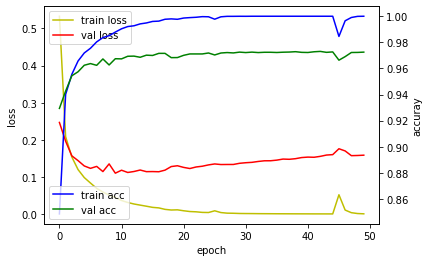

In [20]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [21]:
fig_path=make_dir('./figure')
fig.savefig(fig_path+'/'+'final'+'.png')

## (3) 모델 저장하기, 불러오기
저장하기 : model 객체의 내부 함수인 save() .h5 형식으로 저장할 수 있음 [1.모델의 구조, 2.학습된 파라미터, 3.complie() 설정]

불러오기 : load_model 함수로 .h5 파일에서 모델을 불러올 수 있음

In [22]:
from tensorflow.keras.models import load_model

In [23]:
model = 1
filename = os.listdir(model_path)[-1]
model = load_model(model_path+'/'+filename)

In [24]:
model.fit(X_train_flat, Y_train_onehot, batch_size=256, epochs=3, validation_split=0.3, verbose=2)

Epoch 1/3
165/165 - 1s - loss: 0.0689 - accuracy: 0.9804 - val_loss: 0.1164 - val_accuracy: 0.9664
Epoch 2/3
165/165 - 1s - loss: 0.0621 - accuracy: 0.9814 - val_loss: 0.1266 - val_accuracy: 0.9637
Epoch 3/3
165/165 - 1s - loss: 0.0519 - accuracy: 0.9849 - val_loss: 0.1124 - val_accuracy: 0.9669


In [26]:
model.save(model_path+'/'+'latest_model.h5')

# 3.3 Transfer learning

CIFAR-10 데이터셋은 아래와 같이 총 10개의 label로 이루어진 이미지 분류를 위한 데이터셋이다.

airplane, automobile, bird, cat, deer, dog, frog, horse, ship, and truck.

각각의 레이블마다 32×32 크기 이미지인 50,000개의 training 데이터셋, 10,000개의 test 데이터셋이 존재하고, 결과적으로 총 60,000개의 32×32 크기의 이미지로 데이터셋이 구성되어 있다.

mnist와 다르게 3개의 channel을 가지고 있다.

## (1) 데이터셋 준비

In [27]:
(X_train, Y_train), (X_test, Y_test) = datasets.cifar10.load_data()
print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 1)


label :  [6]


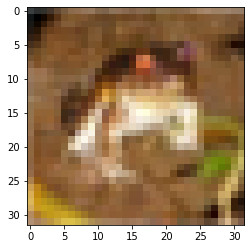

In [28]:
print('label : ',Y_train[0])
plt.imshow(X_train[0])

In [31]:
Y_train = utils.to_categorical(Y_train)
Y_test = utils.to_categorical(Y_test)

print(X_train.shape, Y_train.shape)

(50000, 32, 32, 3) (50000, 10, 2)


## (2) 모델링 <Transfer learning>
    
사용가능 네트워크 :
https://keras.io/api/applications/

In [30]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input

In [31]:
base_model = VGG16(weights='imagenet', input_shape=(32,32,3), include_top=False)
# base_model = VGG16(weights=None, input_shape=(32,32,3), include_top=False)
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

In [32]:
x = base_model.output
x = Flatten()(x)
# let's add a fully-connected layer
x = Dense(256, activation='relu')(x)
# and a logistic layer -- let's say we have 10 classes
predictions = Dense(Y_train.shape[1], activation='softmax')(x)

NameError: name 'base_model' is not defined

In [33]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

NameError: name 'base_model' is not defined

In [34]:
# first: train only the top layers (which were randomly initialized)
for layer in base_model.layers:
    layer.trainable = False

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0   

## (3) 모델의 학습과정 설정

In [36]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

## (4) 모델 학습시키기

In [37]:
history = model.fit(X_train, Y_train, batch_size=128, epochs=20, validation_split=0.2)

Epoch 1/20
313/313 [==============================] - 83s 181ms/step - loss: 6.1677 - accuracy: 0.4025 - val_loss: 1.5706 - val_accuracy: 0.5100
Epoch 2/20
313/313 [==============================] - 3s 8ms/step - loss: 1.3078 - accuracy: 0.5758 - val_loss: 1.4218 - val_accuracy: 0.5493
Epoch 3/20
313/313 [==============================] - 3s 8ms/step - loss: 1.0247 - accuracy: 0.6520 - val_loss: 1.3608 - val_accuracy: 0.5738
Epoch 4/20
313/313 [==============================] - 3s 8ms/step - loss: 0.9062 - accuracy: 0.6911 - val_loss: 1.4117 - val_accuracy: 0.5784
Epoch 5/20
313/313 [==============================] - 3s 8ms/step - loss: 0.8002 - accuracy: 0.7226 - val_loss: 1.4688 - val_accuracy: 0.5872
Epoch 6/20
313/313 [==============================] - 3s 8ms/step - loss: 0.7226 - accuracy: 0.7507 - val_loss: 1.5583 - val_accuracy: 0.5800
Epoch 7/20
313/313 [==============================] - 3s 8ms/step - loss: 0.6506 - accuracy: 0.7758 - val_loss: 1.6714 - val_accuracy: 0.5753
Epo

## (5) 모델 평가하기

In [38]:
loss_and_accuracy = model.evaluate(X_test, Y_test, batch_size=128)
print('loss : %.4f, accruracy : %.4f'%(loss_and_accuracy[0],loss_and_accuracy[1]))

79/79 [==============================] - 0s 6ms/step - loss: 3.5113 - accuracy: 0.5719
loss : 3.5113, accruracy : 0.5719
